# FusionDB reactor browser

Lists all reactors side by side (one column per reactor) with every available field, including derived values. Columns with warnings are highlighted in yellow; mismatches beyond the 1% tolerance are highlighted in red (red overrides yellow). Warning messages are echoed below the table.
from fusdb.reactors_class import relations_for  # dynamic relation access


In [1]:
from pathlib import Path
import numbers
import re
import time
import warnings
import cProfile
import pstats

import pandas as pd  # Pandas is required for styling
import yaml
import sympy as sp

from fusdb.loader import (
    OPTIONAL_METADATA_FIELDS,
    REQUIRED_FIELDS,
    find_reactor_dirs,
    load_reactor_yaml,
)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

PROFILE_TOP = 25
profiler = cProfile.Profile()
profiler.enable()

# Load reactors and capture warnings per reactor and field
root = Path('.')
reactors = {}
cell_status: dict[tuple[str, str], str] = {}
computed_flags: dict[tuple[str, str], bool] = {}
warning_messages: dict[str, list[str]] = {}
explicit_params_by_reactor: dict[str, set[str]] = {}
reserved_keys = set(REQUIRED_FIELDS + OPTIONAL_METADATA_FIELDS)
field_patterns = [
    re.compile(r"^([A-Za-z0-9_]+) violates", re.IGNORECASE),
]

def log(msg: str) -> None:
    print(msg)


def classify_status(msg: str) -> str:
    text = msg.lower()
    if "violates" in text or "not found" in text:
        return "red"
    return "yellow"


def to_display_value(value: object) -> object:
    if isinstance(value, sp.Expr):
        if not value.free_symbols:
            evaluated = value.evalf(chop=True)
            try:
                return float(evaluated)
            except (TypeError, ValueError):
                try:
                    complex_val = complex(evaluated)
                except (TypeError, ValueError):
                    return value
                tol = 1e-12 * max(1.0, abs(complex_val.real))
                if abs(complex_val.imag) <= tol:
                    return float(complex_val.real)
            return value
    return value

def format_sci(value: object) -> str:
    if isinstance(value, numbers.Real) and not isinstance(value, bool):
        if value != 0 and (abs(value) >= 1e3 or abs(value) <= 1e-3):
            return f"{value:.2e}"
    if value is None:
        return ""
    return str(value)


log(f"Loading reactors from {root.resolve()}")

for reactor_dir in find_reactor_dirs(root):
    path = reactor_dir / 'reactor.yaml'
    log(f"Loading {reactor_dir.name}...")

    start = time.perf_counter()
    raw_data = yaml.safe_load(path.read_text()) or {}
    parse_elapsed = time.perf_counter() - start
    explicit_params = set()
    if isinstance(raw_data, dict):
        explicit_params = {key for key in raw_data.keys() if key not in reserved_keys}
    log(f"  Parsed YAML in {parse_elapsed:.2f}s; {len(explicit_params)} explicit params")

    start = time.perf_counter()
    with warnings.catch_warnings(record=True) as caught:
        warnings.simplefilter('always')
        reactor = load_reactor_yaml(path)
    load_elapsed = time.perf_counter() - start
    log(f"  Loaded reactor in {load_elapsed:.2f}s; {len(caught)} warnings")

    reactors[reactor.id] = reactor
    if reactor.relations_used:
        log("  Relations used:")
        for tags, rel in reactor.relations_used:
            tag_label = ", ".join(tags) if tags else "untagged"
            output_name = rel.variables[0] if rel.variables else "?"
            log(f"    - {rel.name} ({output_name}) [{tag_label}]")
    explicit_params_by_reactor[reactor.id] = explicit_params
    for key in reactor.parameters:
        computed_flags[(key, reactor.id)] = key not in explicit_params

    messages = [str(w.message) for w in caught]
    warning_messages[reactor.id] = messages
    for msg in messages:
        field = None
        for pat in field_patterns:
            m = pat.search(msg)
            if m:
                field = m.group(1)
                break
        if field is None:
            continue
        cell_status[(field, reactor.id)] = classify_status(msg)

profiler.disable()
pstats.Stats(profiler).sort_stats("cumtime").print_stats(PROFILE_TOP)
metadata_fields = REQUIRED_FIELDS + OPTIONAL_METADATA_FIELDS
parameter_names = sorted({key for reactor in reactors.values() for key in reactor.parameters.keys()}, key=lambda name: (name.lower(), name))
field_names = metadata_fields + parameter_names

log(f"Building table: {len(metadata_fields)} metadata fields, {len(parameter_names)} parameters")

# Build a DataFrame with metadata + parameter rows
table_data: dict[str, list[object]] = {}
parameter_set = set(parameter_names)
for rid, reactor in sorted(reactors.items()):
    values: list[object] = []
    for name in field_names:
        if name in parameter_set:
            values.append(to_display_value(reactor.parameters.get(name)))
        else:
            values.append(to_display_value(getattr(reactor, name, None)))
    table_data[rid] = values

df = pd.DataFrame(table_data, index=field_names)

def style_cells(data: pd.DataFrame) -> pd.DataFrame:
    styles = pd.DataFrame('', index=data.index, columns=data.columns)
    for field in styles.index:
        for rid in styles.columns:
            parts = []
            if computed_flags.get((field, rid)):
                parts.append('text-decoration: underline;')
            status = cell_status.get((field, rid))
            if status == 'red':
                parts.append('color: #b30000; font-weight: 600;')
            elif status == 'yellow':
                parts.append('color: #b58900;')
            styles.loc[field, rid] = ' '.join(parts)
    return styles

styled = df.style.apply(style_cells, axis=None).format(format_sci)
display(styled)

# Show warnings below the table
for rid, msgs in warning_messages.items():
    if not msgs:
        continue
    print(f'Warnings for {rid}:')
    for msg in msgs:
        print(f' - {msg}')

Loading reactors from /home/alessmor/Scrivania/fusdb
Loading ARC_2015...
  Parsed YAML in 0.01s; 35 explicit params
  Loaded reactor in 1.34s; 3 warnings
  Relations used:
    - tau_E_hubbard_nominal (tau_E) [confinement, tokamak, I-mode]
    - tau_E_iter_ipb98y2 (tau_E) [confinement, tokamak]
    - Thermal pressure (p_th) [plasma]
    - Thermal stored energy (W_th) [plasma]
    - Energy confinement time (tau_E) [plasma]
    - Toroidal beta (beta_T) [plasma]
    - Poloidal beta (beta_p) [plasma]
    - Beta decomposition (beta) [plasma]
    - Normalized beta (beta_N) [plasma]
    - Total auxiliary power (P_aux) [power_exhaust, auxiliary]
    - DT fusion power (Bosch-Hale) (P_fus) [power_exhaust]
    - Major radius (R) [geometry]
    - Aspect ratio (A) [geometry]
    - Elongation (kappa) [geometry]
    - Elongation 95% (kappa) [geometry, tokamak]
    - Triangularity 95% (delta) [geometry, tokamak]
    - Tokamak volume (V_p) [geometry, tokamak]
    - Tokamak surface (S_p) [geometry, tokam

,ARC_2015,DEMO_2018,Hammir2024,InfinityTwo2025,STEP2024EBCC,Stellaris2025
id,ARC_2015,DEMO_2018,Hammir2024,InfinityTwo2025,STEP2024EBCC,Stellaris2025
name,ARC 2015,EU-DEMO 2018,Hammir 2024,INFINITY TWO 2025,STEP 2024 EB-CC,Stellaris 2025
reactor_configuration,compact tokamak,tokamak,spherical tokamak,stellarator,spherical tokamak,stellarator
organization,MIT,EUROFUSION,Realta,TypeOne Energy,UKAEA,Proxima
reactor_family,ARC,DEMO,,,STEP,
country,USA,EUU,,,GBR,
site,,,,,,
design_year,2.02e+03,2.02e+03,2.02e+03,2.02e+03,2.02e+03,2.02e+03
doi,10.1016/j.fusengdes.2015.07.008,10.1016/j.fusengdes.2022.113080,10.1088/1741-4326/ad3fcb,10.1017/S0022377825000364,10.1088/1741-4326/ad6ea2,10.1016/j.fusengdes.2025.114868
notes,Conceptual compact tokamak from MIT.,EU-DEMO Physics Baseline 2018,,,Refers to EC+EBW heating scenario with Conservative Confinement conditions,


Warnings for ARC_2015:
 - beta_N violates Normalized beta relation: expected value is 2.59, got 2.5323589743589743 (holding beta_T=0.019, a=1.13, B0=9.2, I_p=7800000.0)
 - P_fus violates DT fusion power (Bosch-Hale) relation: expected value is 525000000.0, got 438466225.9000916 (holding n_avg=1.3e+20, T_avg=14.0, V_p=153.0)
 - V_p violates Tokamak volume relation: expected value is 153.0, got 141.8281231347786 (holding a=1.13, R=3.3, kappa=1.84, delta=0.5, squareness=0.0)
Warnings for DEMO_2018:
 - P_fus violates DT fusion power (Bosch-Hale) relation: expected value is 2000000000.0, got 2242524187.0833626 (holding n_avg=8.061831837948563e+19, T_avg=12.49, V_p=2568.176489832818)
Warnings for STEP2024EBCC:
 - kappa violates Elongation 95% relation: expected value is 3.0, got 3.136 (holding kappa_95=2.8)
 - kappa violates ST elongation vs aspect ratio relation: expected value is 3.0, got 2.597675981602159 (holding A=1.8)
 - beta_N violates Normalized beta relation: expected value is 0.039

In [2]:
ARC = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/ARC_2015/reactor.yaml')
DEMO = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/DEMO_2018/reactor.yaml')
STEP = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/STEP_2024/reactor.yaml')
Stellaris = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/STELLARIS/reactor.yaml')

/home/alessmor/Scrivania/fusdb/src/fusdb/relation_class.py:376: UserWarning: beta_N violates Normalized beta relation: expected value is 2.59, got 2.5323589743589743 (holding beta_T=0.019, a=1.13, B0=9.2, I_p=7800000.0)
  self.warn_sink(message, UserWarning)
/home/alessmor/Scrivania/fusdb/src/fusdb/relation_class.py:376: UserWarning: P_fus violates DT fusion power (Bosch-Hale) relation: expected value is 525000000.0, got 438466225.9000916 (holding n_avg=1.3e+20, T_avg=14.0, V_p=153.0)
  self.warn_sink(message, UserWarning)
/home/alessmor/Scrivania/fusdb/src/fusdb/relation_class.py:376: UserWarning: V_p violates Tokamak volume relation: expected value is 153.0, got 141.8281231347786 (holding a=1.13, R=3.3, kappa=1.84, delta=0.5, squareness=0.0)
  self.warn_sink(message, UserWarning)
/home/alessmor/Scrivania/fusdb/src/fusdb/relation_class.py:376: UserWarning: P_fus violates DT fusion power (Bosch-Hale) relation: expected value is 2000000000.0, got 2242524187.0833626 (holding n_avg=8.0618

In [3]:
# print Vplasma, Tavg, navg, tauE, fusion power and auxiliary power for the reactors
for reactor in [ARC, DEMO, STEP, Stellaris]:
    Vplasma = reactor.parameters.get('V_p')
    Tavg = reactor.parameters.get('T_avg')
    navg = reactor.parameters.get('n_avg')
    tauE = reactor.parameters.get('tau_E')
    P_fusion = reactor.parameters.get('P_fus')
    P_aux = reactor.parameters.get('P_aux')
    print(f"{reactor.id}: V_plasma={format_sci(Vplasma)}, T_avg={format_sci(Tavg)}, n_avg={format_sci(navg)}, tau_E={format_sci(tauE)}, P_fusion={format_sci(P_fusion)}, P_auxiliary={format_sci(P_aux)}")

ARC_2015: V_plasma=153.000000000000, T_avg=14.0000000000000, n_avg=1.30e+20, tau_E=0.640000000000000, P_fusion=5.25e+8, P_auxiliary=Eq(P_aux, P_NBI + 38600000.0)
DEMO_2018: V_plasma=2.57e+3, T_avg=12.4900000000000, n_avg=8.06e+19, tau_E=Eq(tau_E, 1374403490.65836/P_loss), P_fusion=2.00e+9, P_auxiliary=Eq(P_aux, P_ICRF + P_LHCD + P_NBI)
STEP2024EBCC: V_plasma=788.946436968939, T_avg=9.69000000000000, n_avg=1.64e+20, tau_E=Eq(tau_E, 670214277.645694/P_loss), P_fusion=1.56e+9, P_auxiliary=Eq(P_aux, P_ICRF + P_LHCD + P_NBI)
Stellaris2025: V_plasma=428.000000000000, T_avg=12.0000000000000, n_avg=3.17e+20, tau_E=1.50000000000000, P_fusion=5.30e+9, P_auxiliary=5.00e+7


Skipping Hammir2024: Sauter cross-section requires numeric R and a


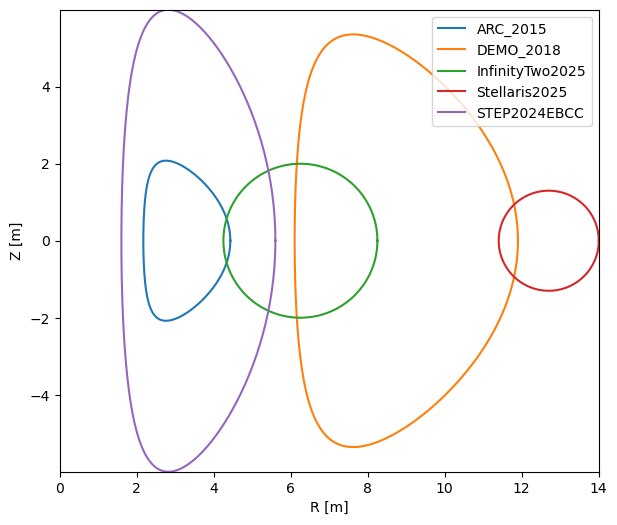

In [4]:
# plot plasma cross-sections (Sauter geometry)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 6))
max_outer = 0.0
max_z = 0.0

for reactor in reactors.values():
    try:
        reactor.plot_cross_section(ax=ax, label=reactor.id)
        line = ax.lines[-1]
        r_vals = line.get_xdata()
        z_vals = line.get_ydata()
    except (ValueError, NotImplementedError) as exc:
        print(f"Skipping {reactor.id}: {exc}")
        continue
    try:
        outer = float(reactor.R) + float(reactor.a)
    except (TypeError, ValueError, AttributeError):
        outer = max(r_vals)
    max_outer = max(max_outer, outer)
    max_z = max(max_z, max(abs(z) for z in z_vals))

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(0, max_outer)
ax.set_ylim(-max_z, max_z)
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.legend()
plt.show()
